# Sheet 10

## 1 Optimal Transport

### (a)

optimal transport objective: 
$$
 \min_{T_{ij}} \sum_{i,j} T_{ij} c(x_i, y_j)
$$
where $ c(x_i, y_j) = \|x_i - y_j\| $ (transportation cost is linear in the distance) and $ T_{ij} \geq 0 $, where $ T_{ij} $ is the amount of mass transported from $ x_i $ to $ y_j $. 

constraints:
$$
\sum_j T_{ij} = a_i, \quad \forall i
$$
ensures $a_i$ is contained

$$
\sum_i T_{ij} = b_j, \quad \forall j
$$
ensures $b_j$ is contained

$$
T_{ij} \geq 0, \quad \forall i, j
$$
nonegativity of transported mass


Straight lines are the shortest paths in euclidean space according to triangle ineqality. This makes straight lines the optimal choice for the objective.


### (b)
$$
Ax=b \Leftrightarrow Ax \leq b, Ax \geq b
$$
$$
\text{minimize }c^TT
$$
c being $c(x_i,y_j)$ vectroized as well as T being $T_{i,j}$ vectorized.

subject to:
$$
A_{row}T=a
$$
$A_{row}T\in\mathbb{R}^{n\times(n \cdot m)}$ has 1s at the appropriate places to sum over j and else 0s.
$$
A_{column}T=b
$$
$A_{column}T\in\mathbb{R}^{m\times(n \cdot m)}$ has 1s at the appropriate places to sum over i and else 0s.
$$
T \geq 0
$$

combine costraints:
$$

A =
\begin{bmatrix}
A_\text{row} \\
A_\text{col}
\end{bmatrix},
\quad
b =
\begin{bmatrix}
a \\
b
\end{bmatrix}.

$$

resulting constraint:
$$

A T = b, \quad T \geq 0,

$$

### (c)

In [1]:
import numpy as np

d = 5
num_sources = 10
num_sinks = 20

np.random.seed(42)
mass_sources = np.random.random(num_sources)
mass_sinks = np.random.random(num_sinks)
mass_sources /= np.sum(mass_sources)
mass_sinks /= np.sum(mass_sinks)

coords_sources = np.random.rand(num_sources, d)
coords_sinks = np.random.rand(num_sinks, d)

In [2]:
# TODO: solve the OT problem as linear program
from scipy.optimize import linprog

c = np.linalg.norm(coords_sources[:, np.newaxis, :]-coords_sinks[np.newaxis, :, :], axis=2)

c = c.flatten()

A_eq_supply = np.zeros((num_sources, num_sources * num_sinks))
for i in range(num_sources):
    A_eq_supply[i, i * num_sinks:(i + 1) * num_sinks] = 1

A_eq_demand = np.zeros((num_sinks, num_sources * num_sinks))
for j in range(num_sinks):
    A_eq_demand[j, j::num_sinks] = 1

A_eq = np.vstack([A_eq_supply, A_eq_demand])
b_eq = np.concatenate([mass_sources, mass_sinks])

bounds = [(0, None) for _ in range(num_sources * num_sinks)]

result = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds)

transportation_cost = result.fun

print("Optimal transportation cost:", transportation_cost)

Optimal transportation cost: 0.6707468352771471


### (d)

The amount of transproted mass is invarian therefore the euclidean distances have to be observed. The total distance from $x_1, x_2$ be two source points to $y_1, y_2$ be two sink points and $p$ being the intersection point can be calculated the following way. Use triangle inequality.
$$
\|x_1 - p\| + \|p-y_1\| \geq \|x_1 - y_1\|
$$
and
$$
\|x_2 - p\| + \|p-y_2\| \geq \|x_2 - y_2\|
$$
$$
\Rightarrow \|x_1 - p\| + \|p-y_1\| + \|x_2 - p\| + \|p-y_2\| = \|x_1 - y_2\| +  \|x_2 - y_1\| \geq  \|x_1 - y_1\| + \|x_2 - y_2\|
$$
with $ \|x_1 - y_1\|, \|x_2 - y_2\|$ being the nonintersecting paths, they minimize the transportation cost.

## 2 Flow matching for generative modeling

### (a)

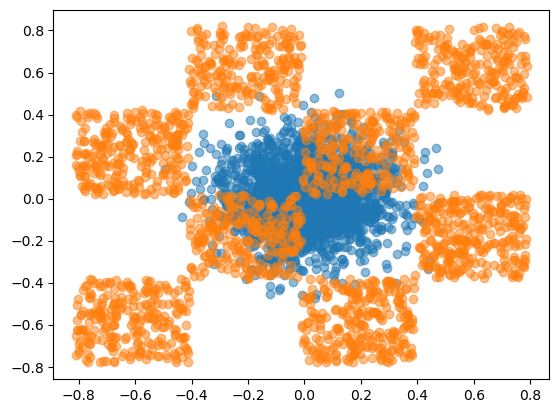

In [3]:
import torch
import matplotlib.pyplot as plt

def generate_checkerboard_sample(num_samples=10, field_size=0.4, num_fields=2, center=True):
    x = torch.rand(num_samples, 2) * field_size
    offset = torch.randint(0, num_fields, (num_samples, 2)) * field_size * 2
    diagonal_shift = torch.randint(0, num_fields, (num_samples, 1)) * field_size
    x += offset + diagonal_shift

    if center:
        x -= torch.mean(x, dim=0)

    return x
    
base_distribution_std = 0.15
num_samples = 2000
x = torch.randn(num_samples, 2) * base_distribution_std
y = generate_checkerboard_sample(num_samples=num_samples)

# show points
plt.scatter(x[:, 0], x[:, 1], alpha=0.5, label='base distribution')
plt.scatter(y[:, 0], y[:, 1], alpha=0.5, label='checkerboard distribution')
plt.show()

In [ ]:
# define a model
import torch
from torchvision.ops import MLP
from tqdm import tqdm

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("device:", device)
model = MLP(in_channels=2 + 1, hidden_channels=[512, 512, 512, 512, 2], activation_layer=torch.nn.SiLU)
model.to(device)

# define a loss function
criterion = torch.nn.MSELoss(reduction="none")

# define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# train the model:
num_epochs = 20000  
batch_size = 4096
losses = []
for epoch in tqdm(range(num_epochs)):
    x = torch.randn(batch_size, 2) * base_distribution_std
    y = generate_checkerboard_sample(num_samples=batch_size)
    x = x.to(device)
    y = y.to(device)

    # TODO: implement the training loop
    # Interpolation between x and y
    t = torch.rand(batch_size, 1).to(device)  # Uniform random values between 0 and 1
    interpolated_points = (1 - t) * x + t * y  # psi_t(x)
    interpolated_points.to(device)

    # Forward pass: compute the velocity field vt for each interpolated point
    vt = model(torch.cat([interpolated_points, t], dim=1))  # Pass (x_t, t) into the model
    
    loss = criterion(vt.squeeze(), (y - x))  
    loss = loss.mean()

    # Backpropagation
    optimizer.zero_grad()  
    loss.backward()  
    optimizer.step()  

    # Store loss for monitoring
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}")

device: mps


  0%|          | 5/20000 [00:00<06:51, 48.57it/s]

Epoch [0/20000], Loss: 0.23223406076431274


  5%|▌         | 1012/20000 [00:11<03:22, 93.83it/s]

Epoch [1000/20000], Loss: 0.1071467250585556


 10%|█         | 2012/20000 [00:21<03:11, 93.75it/s]

Epoch [2000/20000], Loss: 0.1015661433339119


 15%|█▌        | 3011/20000 [00:32<03:02, 92.84it/s]

Epoch [3000/20000], Loss: 0.10226286202669144


 20%|██        | 4011/20000 [00:43<02:51, 93.35it/s]

Epoch [4000/20000], Loss: 0.10295042395591736


 25%|██▌       | 5011/20000 [00:54<02:42, 92.31it/s]

Epoch [5000/20000], Loss: 0.10354366153478622


 30%|███       | 6016/20000 [01:05<02:29, 93.64it/s]

Epoch [6000/20000], Loss: 0.10438300669193268


 35%|███▌      | 7016/20000 [01:15<02:23, 90.44it/s]

Epoch [7000/20000], Loss: 0.10265063494443893


 40%|████      | 8015/20000 [01:26<02:10, 91.68it/s]

Epoch [8000/20000], Loss: 0.09965743869543076


 45%|████▌     | 9015/20000 [01:37<01:58, 92.70it/s]

Epoch [9000/20000], Loss: 0.10580272227525711


 50%|█████     | 10015/20000 [01:48<01:48, 92.42it/s]

Epoch [10000/20000], Loss: 0.09911470115184784


 55%|█████▌    | 11015/20000 [01:59<01:39, 90.34it/s]

Epoch [11000/20000], Loss: 0.10125498473644257


 60%|██████    | 12015/20000 [02:10<01:27, 91.21it/s]

Epoch [12000/20000], Loss: 0.10165396332740784


 65%|██████▌   | 13012/20000 [02:21<01:19, 88.20it/s]

Epoch [13000/20000], Loss: 0.09813179075717926


 70%|███████   | 14012/20000 [02:32<01:08, 87.95it/s]

Epoch [14000/20000], Loss: 0.09878368675708771


 75%|███████▌  | 15011/20000 [02:43<00:55, 89.37it/s]

Epoch [15000/20000], Loss: 0.0995328351855278


 80%|████████  | 16014/20000 [02:54<00:44, 88.68it/s]

Epoch [16000/20000], Loss: 0.10055026412010193


 85%|████████▌ | 17015/20000 [03:06<00:33, 88.54it/s]

Epoch [17000/20000], Loss: 0.10367712378501892


 90%|█████████ | 18012/20000 [03:17<00:22, 88.76it/s]

Epoch [18000/20000], Loss: 0.10173177719116211


 95%|█████████▌| 19009/20000 [03:28<00:11, 86.79it/s]

Epoch [19000/20000], Loss: 0.10043919086456299


100%|██████████| 20000/20000 [03:39<00:00, 90.98it/s]


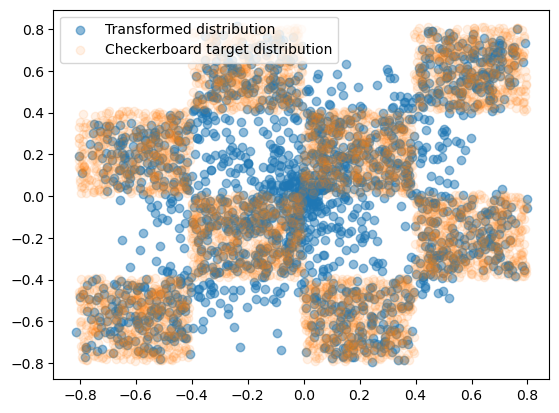

In [27]:
with torch.no_grad():
    x_test = torch.randn(2000, 2) * base_distribution_std  
    x_test = x_test.to(device)
    t_test = torch.rand(2000, 1).to(device) 
    interpolated_test = (1 - t_test) * x_test + t_test * y[:2000]

    vt_test = model(torch.cat([interpolated_test, t_test], dim=1))
    transformed_points = interpolated_test + (1-t_test)*vt_test.squeeze()

    plt.scatter(transformed_points[:, 0].cpu(), transformed_points[:, 1].cpu(), alpha=0.5, label='Transformed distribution')
    plt.scatter(y[:, 0].cpu(), y[:, 1].cpu(), alpha=0.1, label='Checkerboard target distribution')
    plt.legend()
    plt.show()

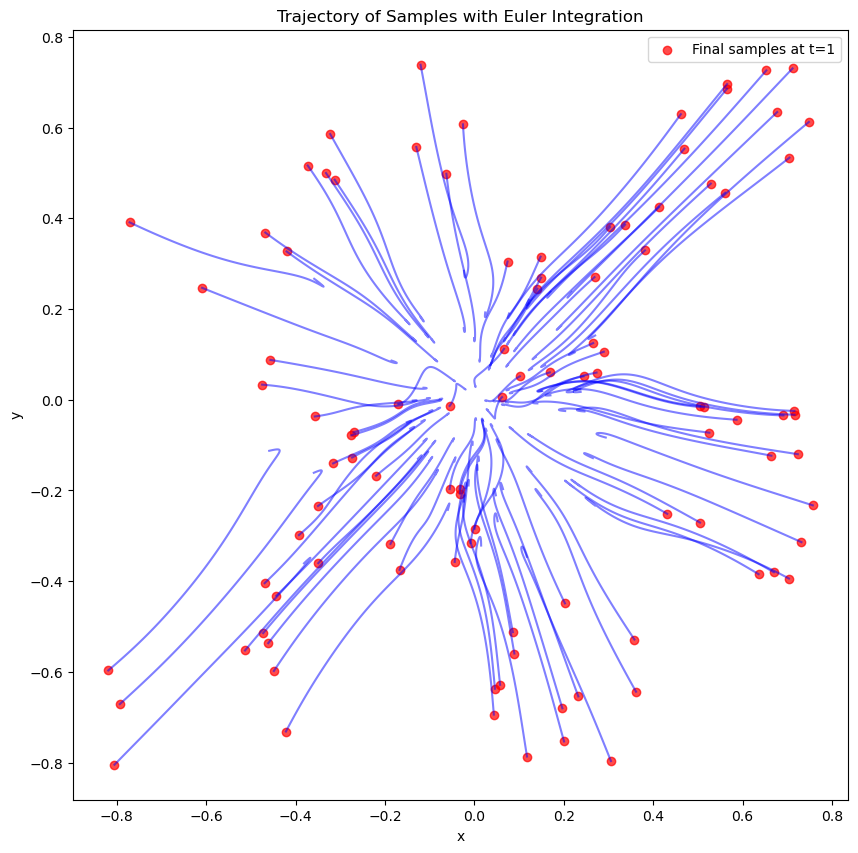

In [36]:
# TODO: run inference with the trained model. 
# Visualize the trajectory of the samples and the final samples at t=1.
# Hint: Use a simple Euler integration scheme to integrate the velocity field with 100 steps.

import numpy as np
import matplotlib.pyplot as plt

# Number of integration steps
num_steps = 100

def euler_integration(model, x_init, device, num_steps=100):
    trajectory = [x_init.cpu().numpy()]  # Store trajectory of samples

    # Initial time (t=0), and final time (t=1)
    t = torch.zeros(x_init.shape[0], 1).to(device)
    
    # Initialize sample positions
    x = x_init.to(device)
    
    # Perform Euler integration
    for step in range(num_steps):
        # Get the velocity field at the current position
        vt = model(torch.cat([x, t], dim=1))  # Forward pass
        
        # Euler integration: x_{t+1} = x_t + delta_t * v_t
        x = x + vt * (1 / num_steps)  # delta_t = 1 / num_steps
        
        # Store the current position
        trajectory.append(x.cpu().detach().numpy())

        # Update time
        t = t + torch.tensor([1/num_steps]).to(device)
    
    return np.array(trajectory)

# Run inference with Euler integration:
num_samples = 100  # Number of samples to generate and track

x_init = torch.randn(num_samples, 2) * base_distribution_std

trajectory = euler_integration(model, x_init, device, num_steps=num_steps)

plt.figure(figsize=(10, 10))
for i in range(num_samples):
    plt.plot(trajectory[:, i, 0], trajectory[:, i, 1], alpha=0.5, color='blue')

# Plot the final samples at t=1
plt.scatter(trajectory[-1, :, 0], trajectory[-1, :, 1], alpha=0.7, color='red', label='Final samples at t=1')

plt.title('Trajectory of Samples with Euler Integration')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### (b)
At $t=0$ the velocity field is $v_0(\psi _0(x_0))=x_1-x_0$ as this minimizes the loss function.

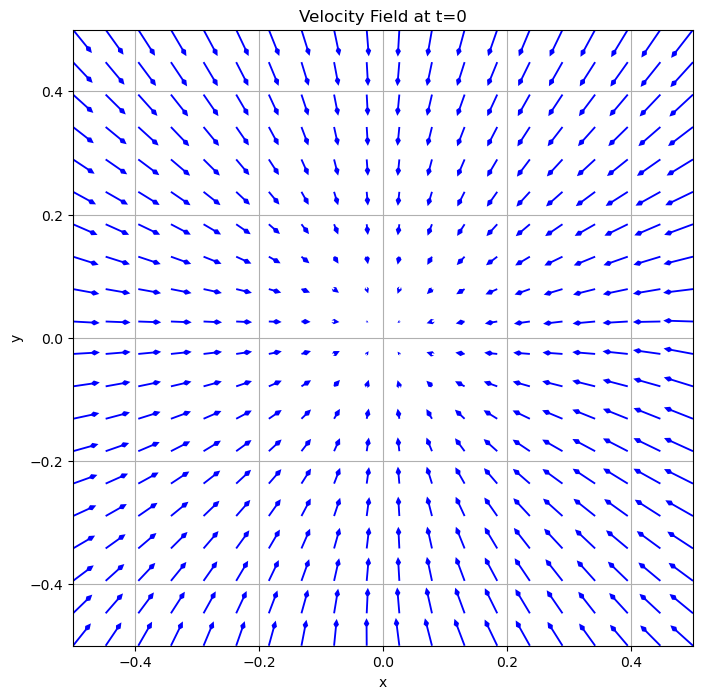

In [42]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Create a grid of points in the range [-0.5, 0.5]^2
grid_size = 20
x_vals = np.linspace(-0.5, 0.5, grid_size)
y_vals = np.linspace(-0.5, 0.5, grid_size)
xx, yy = np.meshgrid(x_vals, y_vals)
grid_points = torch.tensor(np.stack([xx.ravel(), yy.ravel()], axis=1), dtype=torch.float32)

grid_points = grid_points.to(device)

# Set t = 0 for all points
t = torch.zeros(grid_points.shape[0], 1).to(device) # +torch.tensor([0.5]).to(device)

# Get the velocity field v_0 at t = 0
velocity = model(torch.cat([grid_points, t], dim=1))  # [x, y, t] input

# Reshape velocity to match the grid size
vx = velocity[:, 0].cpu().detach().numpy().reshape(grid_size, grid_size)
vy = velocity[:, 1].cpu().detach().numpy().reshape(grid_size, grid_size)

plt.figure(figsize=(8, 8))
plt.quiver(xx, yy, vx, vy, scale=10, color='b', headlength=3)
plt.xlim([-0.5, 0.5])
plt.ylim([-0.5, 0.5])
plt.title("Velocity Field at t=0")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

The velocity field points towards the center at $t=0$ which is not expected but is possible due to not perfect training.

### (c)
The optimal transport for differing distributions does not have to be linear. As it is the case here. Large differences that could be avoided between the initial and the target points lead to inefficient transports. 
Mini batch OT improves the local transport due to the focus on a smaller area. It makes non-linear flows possible. 

## 3 Adversarial attacks and AI safety

### (a) 
Tricking probes as well as adversarial attacks use altered inputs or unusual inputs to change in the former case the activations and in the latter case the outputs. The targer of change is different but the way of achieving it is similar.

### (b)

In [43]:
'''
Logistric regression in pytorch (needed for backpropagation)
taken from https://github.com/saprmarks/geometry-of-truth/blob/main/probes.py
'''

class LRProbe(torch.nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(d_in, 1, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

    def pred(self, x):
        return self(x).round()
    
    def from_data(acts, labels, lr=0.001, weight_decay=0.1, epochs=1000, device='cpu'):
        acts, labels = acts.to(device), labels.to(device)
        probe = LRProbe(acts.shape[-1]).to(device)
        
        opt = torch.optim.AdamW(probe.parameters(), lr=lr, weight_decay=weight_decay)
        for _ in range(epochs):
            opt.zero_grad()
            loss = torch.nn.BCELoss()(probe(acts), labels)
            loss.backward()
            opt.step()
        
        return probe

    def __str__():
        return "LRProbe"

    @property
    def direction(self):
        return self.net[0].weight.data[0]

In [44]:
# We import the DataManager class as a helper function to load the activation vectors for us.
from lie_detection_utils import DataManager
from sklearn.metrics import accuracy_score

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

In [70]:
# train a model on the cities dataset
dataset_name = "cities"

dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device=device, path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
train_acts, train_labels = dm.get('train')
test_acts, test_labels = dm.get('val')

print("train_acts.shape", train_acts.shape)
print("test_acts.shape", test_acts.shape)

# TODO: train a logistic regression probe on the train_acts and train_labels

probe = LRProbe.from_data(train_acts, train_labels, lr=0.001, weight_decay=0.1, epochs=1000, device=device)

# Evaluate on the test set
test_preds = probe.pred(test_acts)
accuracy = accuracy_score(test_labels.cpu().detach().numpy(), test_preds.cpu().detach().numpy())

print(f"Test Accuracy: {accuracy * 100:.2f}%")

train_acts.shape torch.Size([1196, 4096])
test_acts.shape torch.Size([300, 4096])
Test Accuracy: 99.67%


In [71]:
# TODO: optimize a perturbation on a single sample which is a lie
# Select a single lie sample from the test dataset
lie_indices = (test_labels == 0).nonzero(as_tuple=True)[0]  # Indices of all lie samples
single_lie_index = lie_indices[0]  # Choose the first lie sample
single_lie_sample = test_acts[single_lie_index].unsqueeze(0)  # Shape: [1, d_in]
single_lie_sample.requires_grad = True  # Enable gradient tracking for the sample

# Initialize a perturbation vector
perturbation = torch.zeros_like(single_lie_sample, requires_grad=True)

# Define an optimizer for the perturbation
perturb_optimizer = torch.optim.Adam([perturbation], lr=0.01)

# Loss function: binary cross-entropy to make the prediction close to 1
target_label = torch.tensor([1.0]).to(device)  # Desired label (truth)

# Optimize the perturbation
num_iterations = 100
for iteration in range(num_iterations):
    # Add perturbation to the original lie sample
    perturbed_sample = single_lie_sample + perturbation
    perturbed_sample = perturbed_sample.to(device)

    # Get the prediction from the probe
    prediction = probe(perturbed_sample)

    # Compute the loss
    loss = torch.nn.BCELoss()(prediction, target_label)

    # Perform gradient descent
    perturb_optimizer.zero_grad()
    loss.backward()
    perturb_optimizer.step()

    # Optional: Log progress every 50 iterations
    if iteration % 50 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item():.4f}, Prediction: {prediction.item():.4f}")

# Check the final prediction for the perturbed sample
original_prediction = probe(single_lie_sample).item()
perturbed_prediction = probe(single_lie_sample + perturbation).item()
print(f"Original Prediction: {original_prediction:.4f}")
print(f"Perturbed Prediction: {perturbed_prediction:.4f}")

Iteration 0, Loss: 8.0961, Prediction: 0.0003
Iteration 50, Loss: -0.0000, Prediction: 1.0000
Original Prediction: 0.0003
Perturbed Prediction: 1.0000


The BCE Loss is used as in the initial training.

In [72]:
# TODO: check whether this perturbation works on other samples too

# Get all samples labeled as lies (label = 0)
lie_samples = test_acts[test_labels == 0]

# Add the optimized perturbation vector to these samples
perturbed_lie_samples = lie_samples + perturbation.detach()  # Add learned perturbation
perturbed_lie_samples = perturbed_lie_samples.to(device)

# Get predictions for the perturbed samples
perturbed_predictions = probe.pred(perturbed_lie_samples)

# Check how many lie samples are misclassified as truths
num_misclassified = (perturbed_predictions == 1).sum().item()
total_lie_samples = lie_samples.size(0)

print(f"Number of misclassified samples: {num_misclassified}/{total_lie_samples}")
print(f"Percentage misclassified: {num_misclassified / total_lie_samples * 100:.2f}%")

Number of misclassified samples: 149/149
Percentage misclassified: 100.00%


The preditions of the predictor for the lies become falsely predicted as truth.

### (c)

In [101]:
# TODO: add the constraint that the perturbation should be small
# Set a scaling factor for the perturbation constraint
perturbation_scale = 0.05  # Adjust this to control the size of perturbations (smaller = stricter constraint)

perturbation = torch.zeros_like(single_lie_sample, requires_grad=True)

perturb_optimizer = torch.optim.Adam([perturbation], lr=0.01)

# Optimize the perturbation
num_iterations = 100
for iteration in range(num_iterations):
    # Add perturbation to the original lie sample
    perturbed_sample = single_lie_sample + perturbation
    perturbed_sample = perturbed_sample.to(device)

    # Get the prediction from the probe
    prediction = probe(perturbed_sample)

    # Define the new loss function with a perturbation constraint
    loss = torch.nn.BCELoss()(probe(single_lie_sample + perturbation), target_label)  # Original loss
    regularization = perturbation_scale * torch.norm(perturbation, p=2)  # L2 regularization
    total_loss = loss + regularization

    # Perform gradient descent
    perturb_optimizer.zero_grad()
    loss.backward()
    perturb_optimizer.step()

    # Optional: Log progress every 50 iterations
    if iteration % 50 == 0:
        print(f"Iteration {iteration}, Loss: {loss.item():.4f}, Prediction: {prediction.item():.4f}")

# Check the final prediction for the perturbed sample
original_prediction = probe(single_lie_sample).item()
perturbed_prediction = probe(single_lie_sample + perturbation).item()
print(f"Original Prediction: {original_prediction:.4f}")
print(f"Perturbed Prediction: {perturbed_prediction:.4f}")

# Normalize the perturbation to ensure it stays small
with torch.no_grad():
    perturbation.data = torch.clamp(perturbation, min=-perturbation_scale, max=perturbation_scale)

Iteration 0, Loss: 8.0961, Prediction: 0.0003
Iteration 50, Loss: -0.0000, Prediction: 1.0000
Original Prediction: 0.0003
Perturbed Prediction: 1.0000


In [102]:
# Get all samples labeled as lies (label = 0)
lie_samples = test_acts[test_labels == 0]

# Add the optimized perturbation vector to these samples
perturbed_lie_samples = lie_samples + perturbation.detach()  # Add learned perturbation
perturbed_lie_samples = perturbed_lie_samples.to(device)

# Get predictions for the perturbed samples
perturbed_predictions = probe.pred(perturbed_lie_samples)

# Check how many lie samples are misclassified as truths
num_misclassified = (perturbed_predictions == 1).sum().item()
total_lie_samples = lie_samples.size(0)

print(f"Number of misclassified samples: {num_misclassified}/{total_lie_samples}")
print(f"Percentage misclassified: {num_misclassified / total_lie_samples * 100:.2f}%")

Number of misclassified samples: 149/149
Percentage misclassified: 100.00%


The lie detector can't be tricked anymore. The deviation is too small to push the sample over the decision boundary. The dicision boundary is a linear funciton of the activations according to the linear representation hypthesis. 